In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas
import numpy as np
from configparser import ConfigParser
import sqlite3
from datetime import datetime

In [3]:
config = ConfigParser()
config.read("../config.ini")
sqlite_conn_string = config.get(section='NOTEBOOKS', option='sqlite3_conn_string')
conn = sqlite3.connect(sqlite_conn_string)

In [4]:
sqlText = """ SELECT    ArticleAnalysis.*,
                        Legislation.date_posted,
                        VotedLegislation.date_posted as date_voted,
                        Legislation.ministry
                        FROM ArticleAnalysis
LEFT JOIN Legislation on Legislation.Id = ArticleAnalysis.p_legislation_id
LEFT JOIN Legislation as VotedLegislation on VotedLegislation.id = Legislation.final_legislation_id
"""
df = pandas.read_sql_query(sqlText,conn )
df.head()

,p_articleID,p_articleNo,f_articleID,f_articleNo,p_legislation_id,days_diff,diff_count,similarity_ratio,comments_allowed,total_comments,positivity_score,date_posted,date_voted,ministry
0,1,1,47429,1,1,15,85,0.935234,1,134,None,2023-07-10,2023-07-25,Υπουργείο Εσωτερικών
1,2,2,47430,2,1,15,10,0.979424,1,12,None,2023-07-10,2023-07-25,Υπουργείο Εσωτερικών
2,4,1,23146,1,3,12,43,0.780541,1,1,None,2023-03-30,2023-04-11,Υπουργείο Εσωτερικών
3,5,2,23147,2,3,12,143,0.794287,0,0,None,2023-03-30,2023-04-11,Υπουργείο Εσωτερικών
4,6,3,23148,3,3,12,271,0.882559,1,3,None,2023-03-30,2023-04-11,Υπουργείο Εσωτερικών


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12552 entries, 0 to 12551
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   p_articleID       12552 non-null  int64  
 1   p_articleNo       12552 non-null  object 
 2   f_articleID       12552 non-null  int64  
 3   f_articleNo       12552 non-null  object 
 4   p_legislation_id  12552 non-null  int64  
 5   days_diff         12552 non-null  int64  
 6   diff_count        12552 non-null  int64  
 7   similarity_ratio  12552 non-null  float64
 8   comments_allowed  12552 non-null  int64  
 9   total_comments    12552 non-null  int64  
 10  positivity_score  0 non-null      object 
 11  date_posted       12552 non-null  object 
 12  date_voted        12552 non-null  object 
 13  ministry          12552 non-null  object 
dtypes: float64(1), int64(7), object(6)
memory usage: 1.3+ MB


### Prepare Data

In [6]:
def governemnt_period(dt):
    if dt >= datetime(2009,10,9) and dt <= datetime(2011,11,11):
        return "PASOK (Giorgos Papandreou)"
    if dt > datetime(2011,11,11) and dt <= datetime(2012,5,16):
        return "PASOK, New Democracy, LAOS (Loukas Papadimos)"
    if dt > datetime(2012,5,16) and dt <= datetime(2012,6,20):
        return "Caretaker Goverment (Panagiotis Pikramenos)"
    if dt > datetime(2012,6,20) and dt <= datetime(2015,1,16):
        return "New Democracy (Antonis Samaras)"
    if dt > datetime(2015,1,26) and dt <= datetime(2015,8,27):
        return "SYRIZA, ANEL (Alexis Tsipras)"
    if dt > datetime(2015,8,27) and dt <= datetime(2015,9,21):
        return "Caretaker Goverment (Vasiliki Thanou)"
    if dt > datetime(2015,9,21) and dt <= datetime(2019,7,8):
        return "SYRIZA, ANEL (Alexis Tsipras)"
    if dt > datetime(2019,8,9) and dt <= datetime(2023,5,25):
        return "New Democracy (Kyriakos Mitsotakis)"
    if dt > datetime(2023,5,25) and dt <= datetime(2023,7,26):
        return "Caretaker Goverment (Ioannis Sarmas)"
    if dt > datetime(2023,7,26):
        return "New Democracy (Kyriakos Mitsotakis)"

In [7]:
df['date_posted'] = pandas.to_datetime(df['date_posted'])
df['date_posted_y'] = df['date_posted'].dt.year
df['date_posted_m'] = df['date_posted'].dt.month
df['total_comments_q'] = pandas.qcut(df['total_comments'],q=np.linspace(0,1,30),
                                     labels=False,
                                     duplicates='drop')
df['total_comments_q2'] = pandas.qcut(df['total_comments'],q=[0,0.5,0.75,0.9,0.95,0.99,1],
                                     labels=False,
                                     duplicates='drop').astype(str)
df['goverment_period'] = df['date_posted'].apply(governemnt_period)
df.head(10)

,p_articleID,p_articleNo,f_articleID,f_articleNo,p_legislation_id,days_diff,diff_count,similarity_ratio,comments_allowed,total_comments,positivity_score,date_posted,date_voted,ministry,date_posted_y,date_posted_m,total_comments_q,total_comments_q2,goverment_period
0,1,1,47429,1,1,15,85,0.935234,1,134,None,2023-07-10,2023-07-25,Υπουργείο Εσωτερικών,2023,7,10,4,Caretaker Goverment (Ioannis Sarmas)
1,2,2,47430,2,1,15,10,0.979424,1,12,None,2023-07-10,2023-07-25,Υπουργείο Εσωτερικών,2023,7,7,2,Caretaker Goverment (Ioannis Sarmas)
2,4,1,23146,1,3,12,43,0.780541,1,1,None,2023-03-30,2023-04-11,Υπουργείο Εσωτερικών,2023,3,0,0,New Democracy (Kyriakos Mitsotakis)
3,5,2,23147,2,3,12,143,0.794287,0,0,None,2023-03-30,2023-04-11,Υπουργείο Εσωτερικών,2023,3,0,0,New Democracy (Kyriakos Mitsotakis)
4,6,3,23148,3,3,12,271,0.882559,1,3,None,2023-03-30,2023-04-11,Υπουργείο Εσωτερικών,2023,3,2,1,New Democracy (Kyriakos Mitsotakis)
5,7,4,23149,4,3,12,488,0.070305,0,0,None,2023-03-30,2023-04-11,Υπουργείο Εσωτερικών,2023,3,0,0,New Democracy (Kyriakos Mitsotakis)
6,8,5,23150,5,3,12,292,0.719588,1,4,None,2023-03-30,2023-04-11,Υπουργείο Εσωτερικών,2023,3,3,1,New Democracy (Kyriakos Mitsotakis)
7,9,6,23151,6,3,12,138,0.918103,1,7,None,2023-03-30,2023-04-11,Υπουργείο Εσωτερικών,2023,3,5,2,New Democracy (Kyriakos Mitsotakis)
8,10,7,23152,7,3,12,15,0.981818,1,5,None,2023-03-30,2023-04-11,Υπουργείο Εσωτερικών,2023,3,4,2,New Democracy (Kyriakos Mitsotakis)
9,12,9,23154,9,3,12,71,0.818121,0,0,None,2023-03-30,2023-04-11,Υπουργείο Εσωτερικών,2023,3,0,0,New Democracy (Kyriakos Mitsotakis)


Data Sanity Checks

In [8]:
# Check for negative days diff
df[df['days_diff']<0][['p_legislation_id','days_diff']].drop_duplicates()
# Legislation 41 -> correct mapping is with Law 4950 (Bills are the same)
# Legislation 112 -> Wrong Match
# Legislation 245 -> It's mostly the same 
# Legislation 246 -> It's mostly the same

,p_legislation_id,days_diff
1068,41,-174
2558,112,-764
5573,245,-635
5585,246,-635


In [9]:
df = df[df['days_diff']>0]

# Plotting With Matplotlib

#### TODO
1. Restructure `scripts` folder, keep only important scrits and put the rest into different folder
2. add script that populates jaccard similarity and embeddings similarity
3. add script to populate embeddings from file
4. plot data
5. Read Time-Series, matplotlib documentation

In [101]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [11]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [12]:
plt.style.use("classic")

### Plot Similarity Per Time

C:\Users\aneme\AppData\Local\Temp\ipykernel_18732\2633831670.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


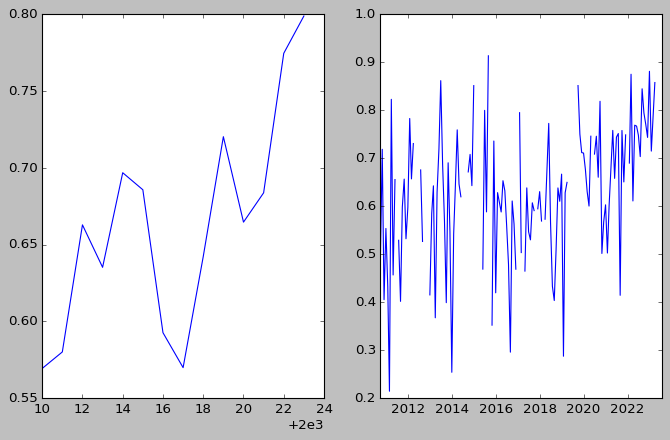

In [13]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,6))
df1 = df.groupby('date_posted_y')['similarity_ratio'].mean()
ax1.plot(df1)

df2 = df[['date_posted','similarity_ratio']]
df2.set_index('date_posted',inplace=True)
df2 = df2.resample("M").mean()
# df2.head()
ax2.plot(df2)
fig.show()

In [14]:
df[[ 'total_comments', 'similarity_ratio','days_diff' ]].describe()

,total_comments,similarity_ratio,days_diff
count,12477.000000,12477.000000,12477.000000
mean,11.423499,0.657993,110.578905
std,139.645446,0.249474,128.417891
min,0.000000,0.050213,6.000000
25%,0.000000,0.482130,36.000000
50%,1.000000,0.723577,76.000000
75%,4.000000,0.871012,144.000000
max,10633.000000,1.000000,1591.000000


In [15]:
df['total_comments'].quantile(np.linspace(0,1,11))

0.0        0.0
0.1        0.0
0.2        0.0
0.3        0.0
0.4        0.0
0.5        1.0
0.6        2.0
0.7        3.0
0.8        6.0
0.9       13.0
1.0    10633.0
Name: total_comments, dtype: float64

In [16]:
df['total_comments'].quantile(np.linspace(.9,1,11))

0.90       13.0
0.91       14.0
0.92       16.0
0.93       19.0
0.94       22.0
0.95       25.2
0.96       32.0
0.97       44.0
0.98       72.0
0.99      142.0
1.00    10633.0
Name: total_comments, dtype: float64

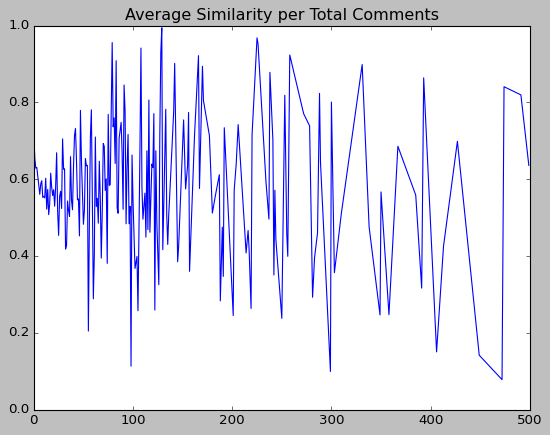

In [17]:
fig, ax = plt.subplots()
df0 = df[df['total_comments']<500]
df0 = df0.groupby(df0['total_comments'])['similarity_ratio'].mean()
ax.plot(df0.index, df0.values)
ax.set_title("Average Similarity per Total Comments")
plt.show()

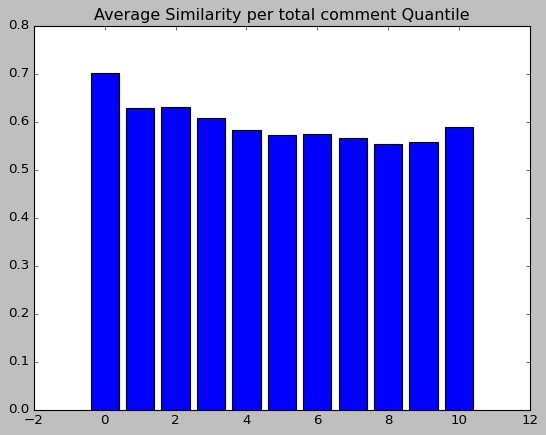

In [18]:
fig, ax = plt.subplots()
df3 = df.groupby('total_comments_q')['similarity_ratio'].mean().reset_index()
df3.head()
# df3['similarity_q'] = pandas.Categorical(df['similarity_q'], categories=range(4), ordered=True)

ax.bar(df3['total_comments_q'],df3['similarity_ratio'])
ax.set_title("Average Similarity per total comment Quantile")
# df3.index
plt.show()

1. scatter plot per total comment and similairity with alpha value
2. add count as a visual cue to indicate high and low count
3. run regression with total comments, days_diff, ministry and goverment
4. run similarities with jaccard and cosine (create view)

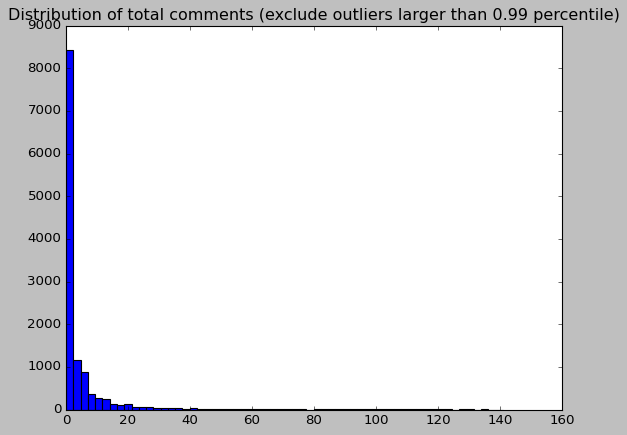

In [19]:
fig, ax = plt.subplots()

ax.hist(df[df['total_comments']<np.quantile(df['total_comments'],q=0.99)]['total_comments'], bins=60)
ax.set_title("Distribution of total comments (exclude outliers larger than 0.99 percentile)")
plt.show()

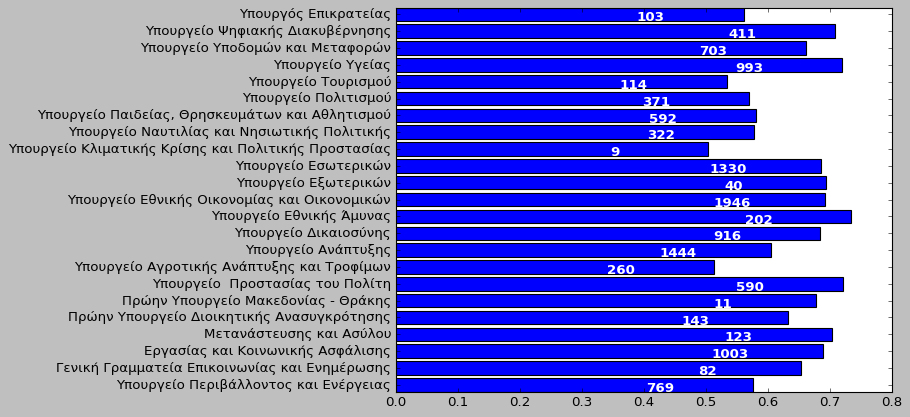

In [20]:
fig, ax = plt.subplots()
df4 = df.groupby('ministry')['similarity_ratio'].agg(['mean','count']).reset_index()

# df4.head()

bars = ax.barh(df4['ministry'], df4['mean'])
              
for bar,count in zip(bars, df4['count']):
    ax.text(bar.get_width()- 0.15,
            bar.get_y(),
            str(count),
            ha='center',
            color='white',
            fontweight='bold' )
plt.show()

C:\Users\aneme\AppData\Local\Temp\ipykernel_16704\1883386213.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color=plt.cm.get_cmap('tab10')(np.arange(len(df4))),

# Plotting with Seaborn

In [61]:
import seaborn as sns
import seaborn.objects as so
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("notebook")
sns.set_palette(palette="tab10")

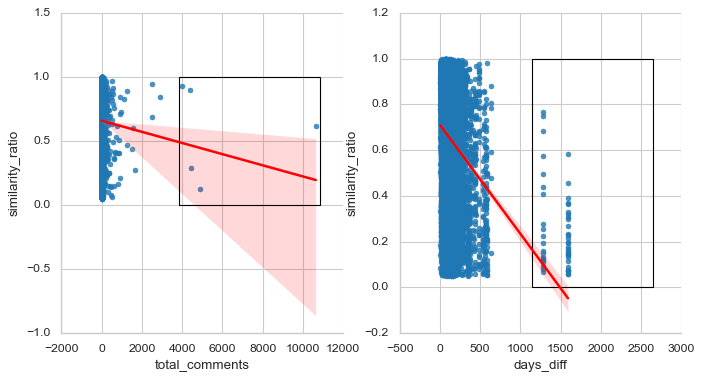

In [113]:
fig, (ax1,ax2) = plt.subplots(ncols=2,nrows=1, figsize=(10,5))
sns.regplot(data=df,
                x="total_comments",
                y="similarity_ratio",
                ax=ax1,
                line_kws={'color':'red'}
                )
sns.regplot(data=df,
                x="days_diff",
                y="similarity_ratio",
                ax=ax2,
                line_kws={'color':'red'}
                )
#Rect: xy, width, height
ax1.add_patch(patches.Rectangle((3850,0),7000,1, edgecolor='black', fill=False))
ax2.add_patch(patches.Rectangle((1150,0),1500,1, fill=False,edgecolor='black'))
sns.despine()


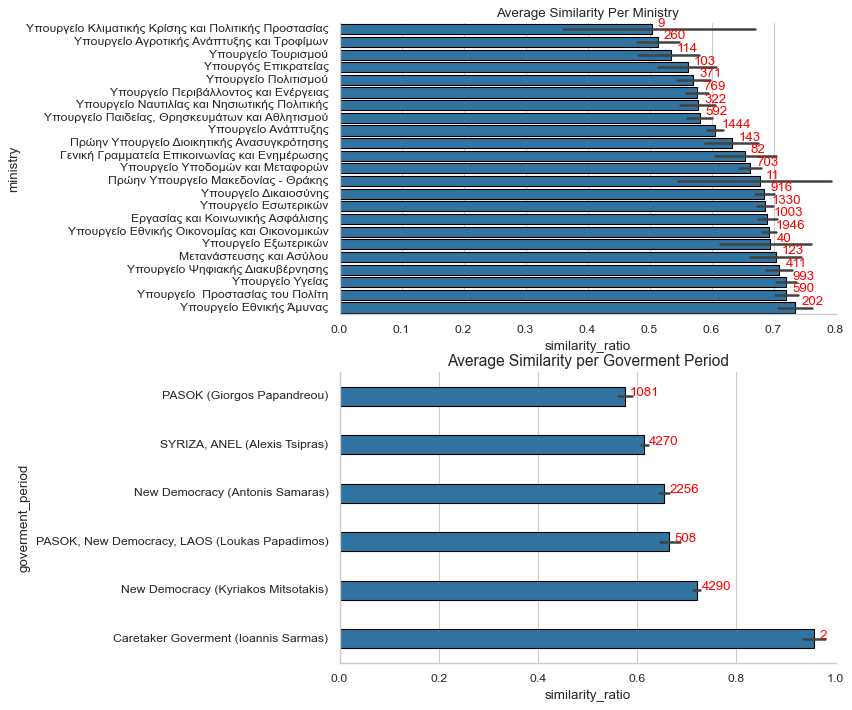

In [135]:
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(8,10))
counts = df.groupby('ministry')['similarity_ratio'].agg([ "mean","count" ]).reset_index().sort_values('mean')['count']
sns.barplot(data=df,
        x='similarity_ratio',
        y='ministry',
        edgecolor='black',
        order=df.groupby('ministry')['similarity_ratio'].mean().reset_index().sort_values('similarity_ratio')['ministry'],
        ax=ax1
        )
for idx,p in enumerate(ax1.patches):
        # print(p.get_x())
        # print(p.get_width())
        ax1.text(p.get_width() + 0.01,p.get_y()+0.2, counts.iloc[idx],color='red')
ax1.set_title("Average Similarity Per Ministry")
counts_2 = df.groupby('goverment_period')['similarity_ratio'].agg([ "mean","count" ]).reset_index().sort_values('mean')['count']
sns.barplot(data=df,
        x='similarity_ratio',
        y='goverment_period',
        edgecolor='black',
        width=0.4,
        order=df.groupby('goverment_period')['similarity_ratio'].mean().reset_index().sort_values('similarity_ratio')['goverment_period'],
        ax=ax2
            )
for idx,p in enumerate(ax2.patches):
        # print(p.get_x())
        # print(p.get_width())
        ax2.text(p.get_width() + 0.01,p.get_y()+0.2, counts_2.iloc[idx],color='red')
ax2.set_title("Average Similarity per Goverment Period",fontsize=14)
sns.despine()
plt.show()

<Axes: xlabel='similarity_ratio', ylabel='ministry'>

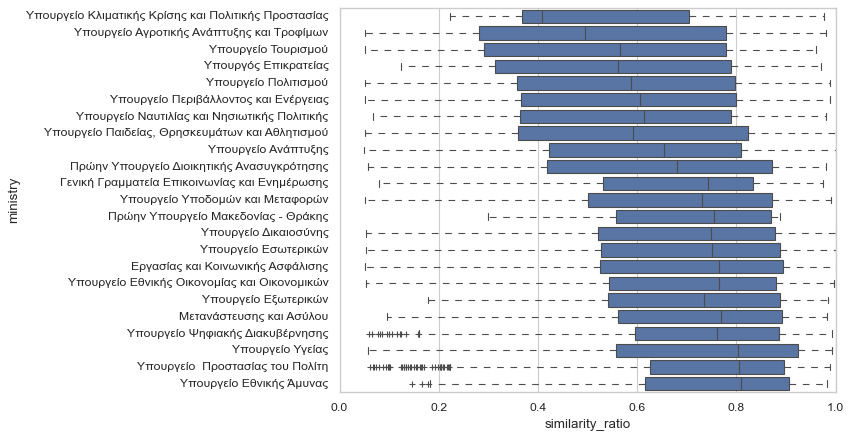

In [137]:
sns.boxplot(data=df,
            x='similarity_ratio',
            y='ministry',
            order=df.groupby('ministry')['similarity_ratio'].mean().reset_index().sort_values('similarity_ratio')['ministry']
)

<Axes: xlabel='total_comments', ylabel='Count'>

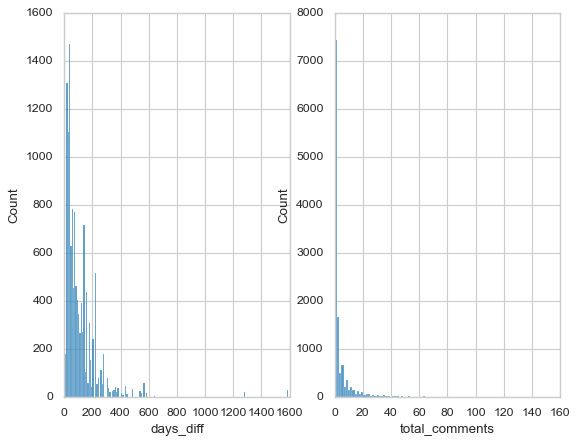

In [144]:
fig, (ax1,ax2) = plt.subplots(ncols=2)

sns.histplot(data=df,
         x='days_diff',
         ax=ax1)
sns.histplot(data=df[df['total_comments']<np.quantile(df['total_comments'],q=0.99)],
         x='total_comments',bins=90,
         ax=ax2)

<Axes: xlabel='total_comments', ylabel='Count'>

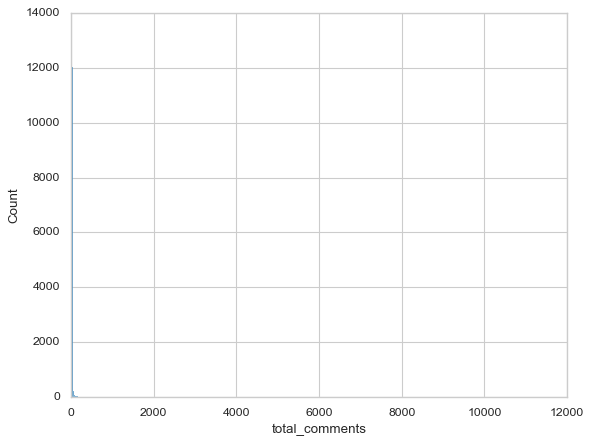

In [139]:
sns.histplot(data=df,
             x='total_comments',bins=300)

# Regressions

In [29]:
import statsmodels.api as sm
from patsy import dmatrices

In [30]:
y, X = dmatrices('similarity_ratio ~ total_comments', data=df, return_type='dataframe')

In [31]:
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       similarity_ratio   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     7.426
Date:                Sat, 27 Jan 2024   Prob (F-statistic):            0.00644
Time:                        14:17:09   Log-Likelihood:                -376.80
No. Observations:               12477   AIC:                             757.6
Df Residuals:                   12475   BIC:                             772.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.6585      0.002    293.

In [32]:
y, X = dmatrices('similarity_ratio ~ total_comments_q2', data=df, return_type='dataframe')
X[3:]  #isCategorical

,Intercept,total_comments_q2[T.1],total_comments_q2[T.2],total_comments_q2[T.3],total_comments_q2[T.4],total_comments_q2[T.5]
3,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0
6,1.0,1.0,0.0,0.0,0.0,0.0
7,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...
12547,1.0,0.0,0.0,0.0,0.0,0.0
12548,1.0,0.0,0.0,0.0,0.0,0.0
12549,1.0,0.0,0.0,0.0,0.0,0.0
12550,1.0,0.0,0.0,0.0,0.0,0.0


In [33]:
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       similarity_ratio   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     130.8
Date:                Sat, 27 Jan 2024   Prob (F-statistic):          1.67e-135
Time:                        14:17:09   Log-Likelihood:                -61.691
No. Observations:               12477   AIC:                             135.4
Df Residuals:                   12471   BIC:                             180.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

In [34]:
y, X = dmatrices('similarity_ratio ~ total_comments_q2 + days_diff', data=df,return_type='dataframe')

In [35]:
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       similarity_ratio   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     262.4
Date:                Sat, 27 Jan 2024   Prob (F-statistic):          2.46e-317
Time:                        14:17:09   Log-Likelihood:                 361.34
No. Observations:               12477   AIC:                            -708.7
Df Residuals:                   12470   BIC:                            -656.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

In [36]:
y, X = dmatrices('similarity_ratio ~ total_comments_q2 + days_diff + ministry', data=df, return_type='dataframe')

In [37]:

mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       similarity_ratio   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     73.78
Date:                Sat, 27 Jan 2024   Prob (F-statistic):               0.00
Time:                        14:17:09   Log-Likelihood:                 577.39
No. Observations:               12477   AIC:                            -1097.
Df Residuals:                   12448   BIC:                            -881.3
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------